In [1]:
# Python 3.10

# Image classification

In this notebook, I will build an image classification model, the model will be trained with images of cats and dogs.</br>
The chosen architecture was ResNet50.

### Importing libraries

In [ ]:
import os
import glob

import cv2
import matplotlib.pyplot as plt
import numpy as np
import onnxruntime as ort
import tensorflow as tf

### Loading and preprocessing data

The images are in my home directory, in the path "datasets/cats_and_dogs", I will use the function `tf.keras.utils.image_dataset_from_directory` to load this data (open the images as a tensor, and generate a datagenerator where each batch will contain the tensors and the labels)

```
~
├── datasets
│   ├── cats_and_dogs
│   │   ├── cats
│   │   │   ├── *.jpg
│   │   ├── dogs
│   │   │   ├── *.jpg
```

In [3]:
# Defining variables
home_directory = os.path.expanduser("~")
images_folder = "datasets/cats_and_dogs"
data_dir = os.path.join(home_directory, images_folder)

IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

In [3]:
# Load train dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


2023-07-21 20:32:54.673893: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2023-07-21 20:32:54.673917: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: taj
2023-07-21 20:32:54.673921: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: taj
2023-07-21 20:32:54.673979: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 525.116.4
2023-07-21 20:32:54.673993: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 525.116.4
2023-07-21 20:32:54.673996: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 525.116.4


In [5]:
# Load validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [5]:
# Class names
class_names = train_ds.class_names
print(class_names)

['cat', 'dog']


### Create model

In [6]:
# Loading pre-trained ResNet model with ImageNet weights
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    classes=2
)

for layer in base_model.layers:
    layer.trainable = False

In [7]:
# Building model
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(64, activation='relu')(x) 
x = tf.keras.layers.Dropout(0.5)(x)
predictions = tf.keras.layers.Dense(2, activation='softmax')(x)

model = tf.keras.Model(inputs = base_model.input, outputs = predictions)

In [8]:
model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer="adam", 
    metrics=["accuracy"]
)

### Train model

In [9]:
# Create model_checkpoint callback
checkpoints_folder = "checkpoints"
os.makedirs(checkpoints_folder, exist_ok=True)

checkpoint_model = os.path.join(checkpoints_folder, "model-{epoch:02d}-{val_loss:.3f}-{accuracy:.3f}-{val_accuracy:.3f}")

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_model,
    mode="max",
    monitor="val_accuracy",
    save_best_only=False,
    save_weights_only=True,
    verbose=0
)

# Create early stopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=1,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [10]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5,
    callbacks=[model_checkpoint, early_stopping_callback]
)

Epoch 1/5
625/625 [==============================] - 714s 1s/step - loss: 0.1944 - accuracy: 0.9360 - val_loss: 0.0638 - val_accuracy: 0.9752
Epoch 2/5
625/625 [==============================] - 711s 1s/step - loss: 0.0844 - accuracy: 0.9721 - val_loss: 0.0540 - val_accuracy: 0.9780
Epoch 3/5
625/625 [==============================] - 708s 1s/step - loss: 0.0742 - accuracy: 0.9745 - val_loss: 0.0507 - val_accuracy: 0.9812
Epoch 4/5
625/625 [==============================] - 694s 1s/step - loss: 0.0656 - accuracy: 0.9776 - val_loss: 0.0461 - val_accuracy: 0.9824
Epoch 5/5
625/625 [==============================] - 705s 1s/step - loss: 0.0610 - accuracy: 0.9782 - val_loss: 0.0452 - val_accuracy: 0.9848


### Plot train metrics

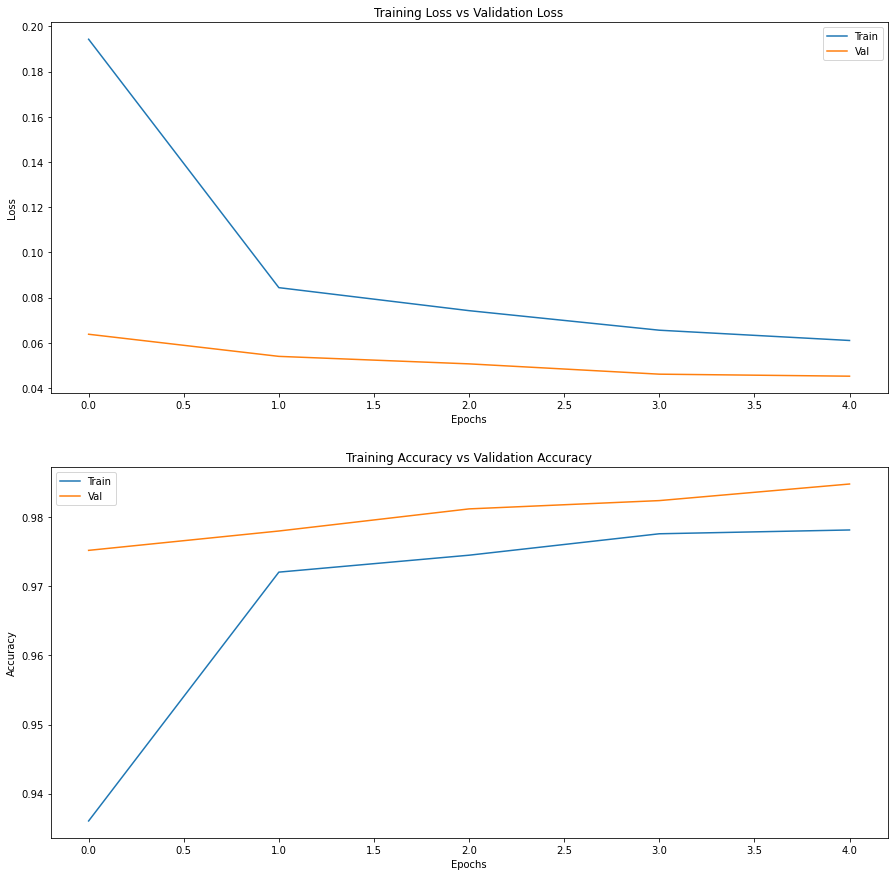

In [12]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend(['Train','Val'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend(['Train', 'Val'])

### Evaluate model

In [13]:
metrics = model.evaluate(val_ds)
print(f"Loss: {metrics[0]}\nAccuracy: {metrics[1]}")

157/157 [==============================] - 136s 866ms/step - loss: 0.0452 - accuracy: 0.9848
Loss: 0.04524622857570648
Accuracy: 0.9847999811172485


### Save model

In [11]:
model.save("models/cats_and_dogs.model")

# To load saved model
# model = tf.keras.models.load_model("cats_and_dogs.model")

INFO:tensorflow:Assets written to: cats_and_dogs.model/assets


INFO:tensorflow:Assets written to: cats_and_dogs.model/assets


### Convert model to ONNX format

[ONNX](https://onnx.ai/) is an open-source standard that makes it easy to move deep learning models between different frameworks and hardware platforms. It provides a set of tools for optimizing and quantizing models, and it is supported by a wide range of companies and organizations. As a result, ONNX is becoming an important standard for deep learning, making it easy to share models and deploy them across different platforms.

In [4]:
os.system("python -m tf2onnx.convert --saved-model models/cats_and_dogs.model --output models/cats_and_dogs.onnx")

/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2023-07-21 21:48:56,407 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2023-07-21 21:48:59,917 - INFO - Signatures found in model: [serving_default].
2023-07-21 21:48:59,917 - WARNING - '--signature_def' not specified, using first signature: serving_default
2023-07-21 21:48:59,918 - INFO - Output names: ['dense_4']
2023-07-21 21:49:02,373 - INFO - Using tensorflow=2.11.0, onnx=1.13.0, tf2onnx=1.14.0/8f8d49
2023-07-21 21:49:02,373 - INFO - Using opset <onnx, 15>
2023-07-21 21:49:02,640 - INFO - Computed 0 values for constant folding
2023-07-21 21:49:03,194 - INFO - Optimizing ONNX model
2023-07-21 21:49:04,262 - INFO - After optimization: Add -1 (22->21), BatchNormalization -53 (53->0), Const -161 (279->118), GlobalAveragePool +1

0

### Load ONNX model and make inference

In [64]:
def onnx_session(model_path):
    """
    Create onnx session
    Args:
        model_path (str): path to onnx model
    Returns:
        sess (onnxruntime.InferenceSession): onnx session
        input_shape (tuple): shape of input
    """
    sess = ort.InferenceSession(model_path)
    input_shape = (sess.get_inputs()[0].shape[1], sess.get_inputs()[0].shape[2])

    return sess, input_shape

def predict(sess, data):
    """
    Predict class of image
    Args:
        sess (onnxruntime.InferenceSession): onnx session
        data (np.array): image array
    Returns:
        preds (np.array): array of predictions
    """
    input_name = sess.get_inputs()[0].name
    outputs = sess.run(
        output_names=None, 
        input_feed={input_name: np.array(data, dtype="float32")}
    )
    
    return outputs

def read_image(img_path, shape=None):
    """
    Read image from path and resize it to shape
    Args:
        img_path (str): path to image
        shape (tuple): shape to resizeimage
    Returns:
        image (np.array): image array
    """
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, shape)
    return image
    
def plot_images(filepaths, predictions, labels=["cat", "dog"], rows=4, columns=3, figsize=(10,10)):

    fig = plt.figure(figsize=figsize)
    for n, file in enumerate(filepaths):
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Adds a subplot in fig
        fig.add_subplot(rows, columns, n + 1)

        predicted_class = np.argmax(predictions[n])
        label = labels[predicted_class]

        # showing image
        plt.imshow(img)
        plt.title(f"{label}")
        plt.axis('off')

In [5]:
# Create session
sess, input_shape = onnx_session("models/cats_and_dogs.onnx")

In [40]:
# List images
filepaths = glob.glob("examples/*.jpg")

In [41]:
# Read images and covert to numpy array
data = [read_image(i, shape=input_shape) for i in filepaths]

In [42]:
# Make inference
preds = predict(sess, data)

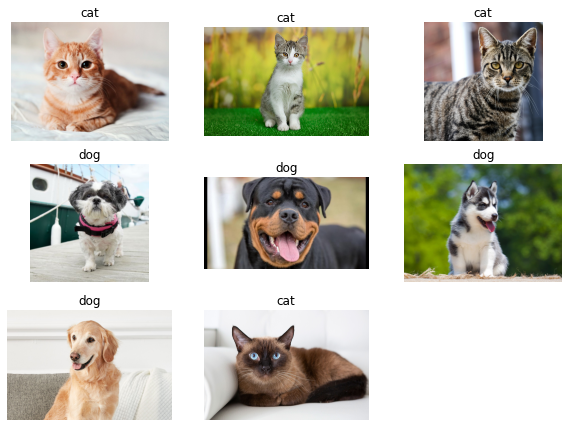

In [65]:
plot_images(filepaths, preds[0])